In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
import flood_tool.geo

from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression,LinearRegression,SGDRegressor,SGDClassifier,Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,confusion_matrix,f1_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import naive_bayes
from sklearn.svm import SVR,SVC

In [2]:
# From prob to riskLabel
def classify_y_pred(flood_prob):
    flood_event = np.array([1,0.5,1,5,10,15,20,30,40,50])
    distances = abs(flood_event - flood_prob)
    flood_class = np.argmin(distances) + 1
    return flood_class

### Load our model

In [3]:
model = pickle.load(open('risklabel_pipeline.pkl','rb'));

In [4]:
model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'altitude'], dtype='object')),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['soilType'], dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(max_depth=71, min_samples_leaf=2,
                                       min_samples_split=6,
                                       n_estimators=402))])

### Load unlabelled data

In [5]:
unlabelled_data = pd.read_csv('resources/postcodes_unlabelled.csv')

In [6]:
"""
Convert easting and northing to latitude and longitude
"""
lat_long = np.vstack(geo.get_gps_lat_long_from_easting_northing(unlabelled_data.easting,unlabelled_data.northing))
unlabelled_data.easting = lat_long[0]
unlabelled_data.northing = lat_long[1]

In [7]:
'''
Drop those columns we consider less important for predicting the flood.
We will use: location(easting,northing),altitude,soilType for modelling.
'''
columns_to_drop = ['postcode','sector', ]#'localAuthority']
X = unlabelled_data.drop(columns=columns_to_drop)

In [8]:
pred_prob = model.predict(X)

In [9]:
pred_label = pd.Series(pred_prob).apply(lambda y: classify_y_pred(y))

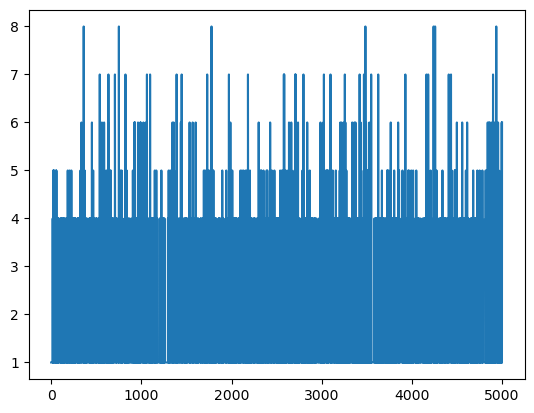

In [10]:
plt.plot(pred_label)

In [11]:
pred_label.value_counts().sort_index()

1    4165
4     614
5     133
6      52
7      29
8       7
dtype: int64

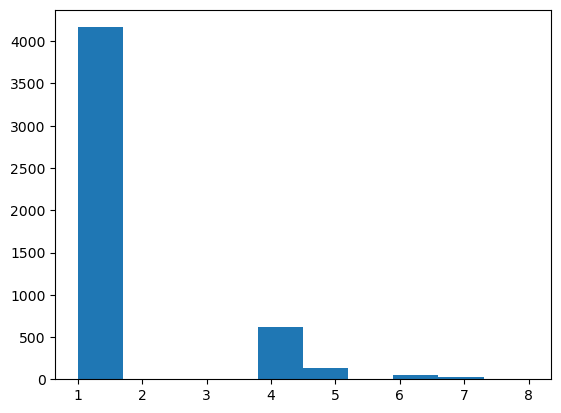

In [14]:
plt.hist(pred_label);